# Vaccination optimisation on an SIR model using JuMP.jl 

Initial version [here](https://github.com/epirecipes/sir-julia/blob/master/markdown/function_map_vaccine_jump/function_map_vaccine_jump.md) by Simon Frost (@sdwfrost)\
Current version Sandra Montes (@slmontes), 2025-03-10

## Introduction

This example examines the optimal control of an SIR model through vaccination, which reduces the number of susceptible individuals according to the following set of equations:

$$
\begin{align*}
\dfrac{\mathrm dS}{\mathrm dt} &= -\beta S I - \upsilon(t) S, \\
\dfrac{\mathrm dI}{\mathrm dt} &= \beta S I - \gamma I,\\ 
\dfrac{\mathrm dC}{\mathrm dt} &= \beta S I\\
\end{align*}
$$

Similar to our previous examples, the population is divided into three categories: susceptible individuals (`S`), infected individuals (`I`), and the total number of cases (`C`). However in this case, Susceptible individuals are vaccinated at a per-capita rate `υ(t)`. 

The optimal control problem is defined as the policy that minimises the total number of cases (i.e., the final size of the epidemic) while adhering to the following constraints: (a) the vaccination rate, `υ`, cannot exceed a maximum value, indicating a limit on the rate of vaccination, and (b) there is a cost associated with the vaccination process, measured as the integral of `υ(t)*S(t)` over time, which cannot exceed a predetermined level. Again, we determine the optimal policy numerically using a simple Euler discretisation and then JuMP.jl with IPOPT to optimise.

## Libraries

In [1]:
using OrdinaryDiffEq
using DiffEqCallbacks
using JuMP
using Ipopt
using Plots
using DataInterpolations
using NonlinearSolve;

## Functions

ODE system

In [2]:
function sir_ode!(du,u,p,t)
    (S, I, C) = u
    (β, γ, υ) = p
    @inbounds begin
        du[1] = -β*S*I - υ*S
        du[2] = β*S*I - γ*I
        du[3] = β*S*I
    end
    nothing
end;

## Running the model without intervention

Parameters

In [3]:
u0 = [0.99, 0.01, 0.0]; #S, I, C (cumulative incidence)
p = [0.5, 0.25, 0]; # β, γ, υ

In [4]:
t0 = 0.0
tf = 100
dt = 0.1
ts = collect(t0:dt:tf)
alg = Tsit5();

Using ODEProblem

In [5]:
prob1 = ODEProblem(sir_ode!, u0, (t0, tf), p)
sol1 = solve(prob1, alg, saveat=ts);

Without control the peak fraction of infected individuals is $\sim 16\%$

In [6]:
peak_value, peak_index = findmax(sol1[2, :]) 
println("The maximum fraction of infected at a `dt` time is: ", peak_value)

The maximum fraction of infected at a `dt` time is: 0.15845528864997238


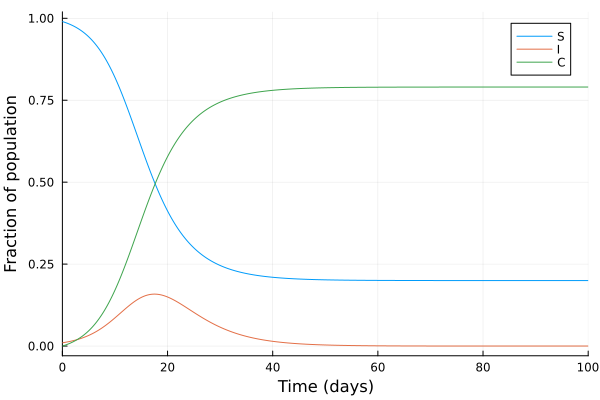

In [7]:
plot(sol1,
     xlim=(0, 100),
     labels=["S" "I" "C"],
     xlabel="Time (days)",
     ylabel="Fraction of population")

## Searching for the optimal intervention constrained by maximum vaccination rate `υ_max`, and cost

Parameters

In [8]:
p2 = copy(p)
p2[3] = 0.05;   #Set maximum vaccination rate to 0.05
β = p2[1]
γ = p2[2]
υ_max = p2[3]
υ_total = 1     # Maximum cost

S0 = u0[1]
I0 = u0[2]
C0 = u0[3]

T = Int(tf/dt)

silent = true;

Model setup

In [9]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "max_iter", 1000)
if !silent
    set_optimizer_attribute(model, "output_file", "JuMP_ftc.txt")
    set_optimizer_attribute(model, "print_timing_statistics", "yes")
end;

Variables:

From their definition, the variables `S`, `I` and `C` are constrained to values between 0 and 1. We constrain our vaccination policy, `υ(t)` to lie between 0 and `υ_max`.


In [10]:
@variable(model, 0 <= S[1:(T+1)] <= 1)
@variable(model, 0 <= I[1:(T+1)] <= 1)
@variable(model, 0 <= C[1:(T+1)] <= 1)
@variable(model, 0 <= υ[1:(T+1)] <= υ_max);

We discretise the SIR model using a simple Euler discretisation:

In [11]:
@expressions(model, begin
        infection[t in 1:T], β * I[t] * dt * S[t]  
        recovery[t in 1:T], γ * dt * I[t] 
        vaccination[t in 1:T], υ[t]* dt * S[t] 
    end);

We constrain the integral of the intervention to be less than or equal to `υ_total`, assuming that the intervention is piecewise constant during each time step.

In [12]:
@constraints(model, begin
    S[1]==S0
    I[1]==I0
    C[1]==C0
    [t=1:T], S[t+1] == S[t] - infection[t] - vaccination[t]
    [t=1:T], I[t+1] == I[t] + infection[t] - recovery[t]
    [t=1:T], C[t+1] == C[t] + infection[t]
    dt * sum(υ[t]*S[t] for t in 1:T+1) <= υ_total
end);

This scenario's objective is to minimise the total number of cases:

In [13]:
@objective(model, Min, C[T+1]);

In [14]:
if silent
    set_silent(model)
end
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [15]:
termination_status(model)

LOCALLY_SOLVED::TerminationStatusCode = 4

In [16]:
S_opt = value.(S)
I_opt = value.(I)
C_opt = value.(C)
υ_opt = value.(υ);

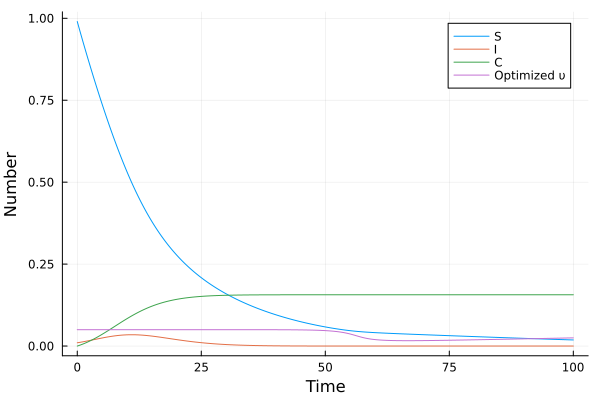

In [17]:
plot(ts, S_opt, label="S", xlabel="Time", ylabel="Number")
plot!(ts, I_opt, label="I")
plot!(ts, C_opt, label="C")
plot!(ts, υ_opt, label="Optimized υ")

With the optimised vaccine intervention, we can observe that the maximum number of fraction of infected is $\sim 3\%$ 

In [18]:
peak_value_opt, peak_index_opt = findmax(I_opt) 
println("The maximum fraction of infected at a `dt` time is: ", peak_value_opt)

The maximum fraction of infected at a `dt` time is: 0.034552884095835804


Again, we can calculate the effective reproductive number, `Rₜ′` in the presence of the intervention:

In [19]:
Rₜ_opt = β.* S_opt ./γ   #Not taking into account the intervention
Rₜ′_opt = Rₜ_opt .* (1 .- υ_opt);  #Taking into account the intervention

And the time at which `Rₜ==1` using a root-finding approach:

In [20]:
Rₜ_interp = CubicSpline(Rₜ_opt,ts)
f(u, p) = [Rₜ_interp(u[1]) - 1.0]
u0 = [(tf-t0)/5]
Rtprob = NonlinearProblem(f, u0)
Rtsol = solve(Rtprob, NewtonRaphson(), abstol = 1e-9).u[1];

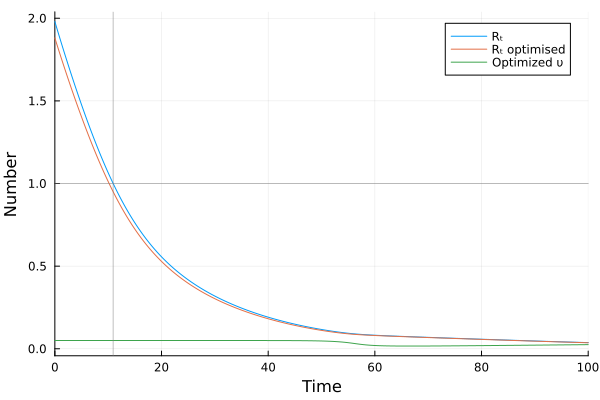

In [21]:
plot(ts, Rₜ_opt, label="Rₜ", xlabel="Time", ylabel="Number", legend=:topright, xlim=(0,100))
plot!(ts, Rₜ′_opt, label="Rₜ optimised")
plot!(ts, υ_opt, label="Optimized υ")
vline!([Rtsol], color=:gray, alpha=0.5, label=false)
hline!([1.0], color=:gray, alpha=0.5, label=false)

## Discussion

Assuming that a vaccine is available at the start of an epidemic, the results in this example suggest that the optimal policy is to vaccinate early and at the maximum level available until the vaccine supply is exhausted. 

The plot of `Rₜ` over time shows that, in this scenario as well as in the lockdown scenario, the optimal policy does not aim to keep `Rₜ` at or below 1 to prevent an increase in the infected population. Instead, it focuses on using the available vaccine supply to achieve the lowest possible total number of cases.